--- HIFT Engine v3.4: Calibrated Robustness Test ---
--- Generating main E8 sample and projecting (this may take a while)... ---

--- Starting 100 randomized 3D rotation runs... ---
Run 10/100 complete...
Run 20/100 complete...
Run 30/100 complete...
Run 40/100 complete...
Run 50/100 complete...
Run 60/100 complete...
Run 70/100 complete...
Run 80/100 complete...
Run 90/100 complete...
Run 100/100 complete...

--- All runs complete. Generating final plot. ---


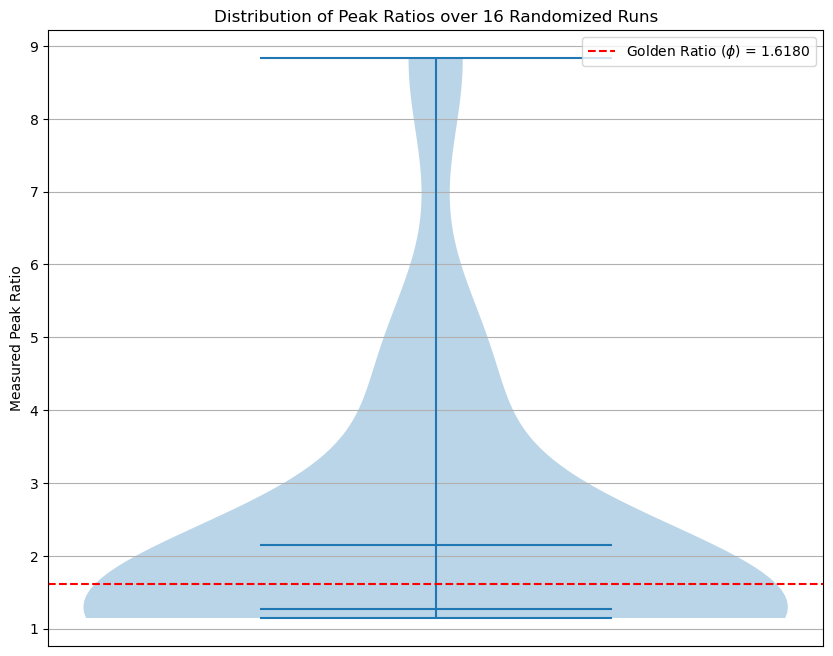

In [4]:
# HIFT-Engine v3.4 - Calibrated Robustness Test
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import maximum_filter
from scipy.spatial.transform import Rotation as R

# --- All helper functions from before (sampling, projection, etc.) ---

def is_e8_vector(vec):
    vec = np.asarray(vec)
    is_integer = np.all(np.abs(vec - np.round(vec)) < 1e-9)
    is_half_integer = np.all(np.abs(vec - (np.round(vec - 0.5) + 0.5)) < 1e-9)
    if is_integer or is_half_integer:
        return np.sum(vec) % 2 < 1e-9
    return False

def generate_e8_sample(num_points, radius, seed=0):
    rng = np.random.default_rng(seed)
    pts, tries, max_tries = [], 0, num_points * 500
    while len(pts) < num_points and tries < max_tries:
        sample_pt = np.round(rng.uniform(-radius, radius, 8) * 2) / 2
        if is_e8_vector(sample_pt) and np.linalg.norm(sample_pt) <= radius:
            if not any(np.allclose(p, sample_pt) for p in pts):
                pts.append(sample_pt)
        tries += 1
    if tries >= max_tries:
        print(f"Warning: Stopped after {max_tries} tries, found {len(pts)} points.")
    return np.array(pts)

def get_canonical_projection_matrices():
    phi = (1 + np.sqrt(5)) / 2
    p1 = np.array([phi, 1, 0, 0, -phi, 1, 0, 0])
    p2 = np.array([1, -phi, 0, 0, 1, phi, 0, 0])
    p3 = np.array([0, 0, phi, 1, 0, 0, -phi, 1])
    p4 = np.array([0, 0, 1, -phi, 0, 0, 1, phi])
    P_4D_parallel = np.array([p1, p2, p3, p4]) / np.sqrt(2 * (1 + phi**2))
    P_3D_parallel_basis = P_4D_parallel[:3, :]
    proj_parallel = P_3D_parallel_basis.T
    U, _, _ = np.linalg.svd(proj_parallel, full_matrices=True)
    proj_perp = U[:, 3:]
    return proj_parallel, proj_perp

def perform_cut_and_project(points_8d, proj_parallel, proj_perp, window_radius):
    points_3d = points_8d @ proj_parallel
    points_5d_perp = points_8d @ proj_perp
    perp_norms = np.linalg.norm(points_5d_perp, axis=1)
    accepted_indices = np.where(perp_norms <= window_radius)
    return points_3d[accepted_indices]

def find_peak_ratio(points_3d, grid_size=128):
    if len(points_3d) < 50: return np.nan # Need enough points to form a clear pattern
    grid = np.zeros((grid_size, grid_size, grid_size))
    p_min, p_max = np.min(points_3d), np.max(points_3d)
    points_normalized = (points_3d - p_min) / (p_max - p_min) * (grid_size - 1)
    points_indices = np.round(points_normalized).astype(int)
    for idx in points_indices:
        if np.all(idx < grid_size) and np.all(idx >= 0):
            grid[idx[0], idx[1], idx[2]] = 1
    S_k = np.abs(np.fft.fftn(grid))**2
    S_k = np.fft.fftshift(S_k)
    S_k_slice = S_k[:, :, grid_size // 2]
    center = grid_size // 2
    y, x = np.indices((grid_size, grid_size))
    radii_pixels = np.sqrt((x - center)**2 + (y - center)**2)
    radial_bins = np.arange(0, grid_size // 2, 1)
    radial_profile = np.zeros(len(radial_bins))
    for i in range(len(radial_bins) - 1):
        mask = (radii_pixels >= radial_bins[i]) & (radii_pixels < radial_bins[i+1])
        if np.any(mask):
            radial_profile[i] = S_k_slice[mask].mean()
    search_area = radial_profile[5:]
    peaks, _ = find_peaks(search_area, height=np.mean(search_area) * 1.5, distance=5)
    peaks = peaks + 5
    if len(peaks) >= 2:
        peak_intensities = radial_profile[peaks]
        sorted_indices = np.argsort(peak_intensities)[::-1]
        strongest_peak = peaks[sorted_indices[0]]
        second_strongest_peak = peaks[sorted_indices[1]]
        return max(strongest_peak, second_strongest_peak) / min(strongest_peak, second_strongest_peak)
    return np.nan

# ----------------------- MAIN EXECUTION BLOCK -----------------------

if __name__ == '__main__':
    print("--- HIFT Engine v3.4: Calibrated Robustness Test ---")
    
    NUM_RUNS = 100
    JITTER_STRENGTH = 0.05 # Using a much smaller, 5% jitter
    
    print("--- Generating main E8 sample and projecting (this may take a while)... ---")
    e8_sample = generate_e8_sample(num_points=200000, radius=5.0)
    proj_parallel, proj_perp = get_canonical_projection_matrices()
    projected_points_base = perform_cut_and_project(e8_sample, proj_parallel, proj_perp, window_radius=2.15)
    
    print(f"\n--- Starting {NUM_RUNS} randomized 3D rotation runs... ---")
    peak_ratios = []
    
    for i in range(NUM_RUNS):
        # Create a small, random perturbation from the identity matrix
        random_rotation_3d = R.random(random_state=i).as_matrix()
        jitter_matrix = np.identity(3) * (1 - JITTER_STRENGTH) + random_rotation_3d * JITTER_STRENGTH
        
        # Apply the small jitter to the 3D points
        jittered_points_3d = projected_points_base @ jitter_matrix
        
        ratio = find_peak_ratio(jittered_points_3d, grid_size=128)
        if not np.isnan(ratio):
            peak_ratios.append(ratio)
        
        if (i + 1) % 10 == 0:
            print(f"Run {i+1}/{NUM_RUNS} complete...")

    print("\n--- All runs complete. Generating final plot. ---")
    
    if len(peak_ratios) > 0:
        plt.figure(figsize=(10, 8))
        plt.violinplot(peak_ratios, showmeans=True, showmedians=True)
        
        phi = (1 + np.sqrt(5)) / 2
        plt.axhline(y=phi, color='r', linestyle='--', label=f'Golden Ratio ($\phi$) = {phi:.4f}')
        
        plt.title(f"Distribution of Peak Ratios over {len(peak_ratios)} Randomized Runs")
        plt.ylabel("Measured Peak Ratio")
        plt.xticks([])
        plt.grid(True)
        plt.legend()
        plt.show()
    else:
        print("No valid peak ratios were found across all runs. The jitter may still be too strong or the sample size too small.")